In [0]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/AIML_NoteBooks/LabAndAssignments/kc_house_data.csv')

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [6]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [7]:
df.nunique()

id               21436
date               372
price             4028
bedrooms            13
bathrooms           30
sqft_living       1038
sqft_lot          9782
floors               6
waterfront           2
view                 5
condition            5
grade               12
sqft_above         946
sqft_basement      306
yr_built           116
yr_renovated        70
zipcode             70
lat               5034
long               752
sqft_living15      777
sqft_lot15        8689
dtype: int64

In [8]:
df.apply(lambda x: sum(x.isnull()))

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

**Data Visualization with Correlation matrix for Input variables:**

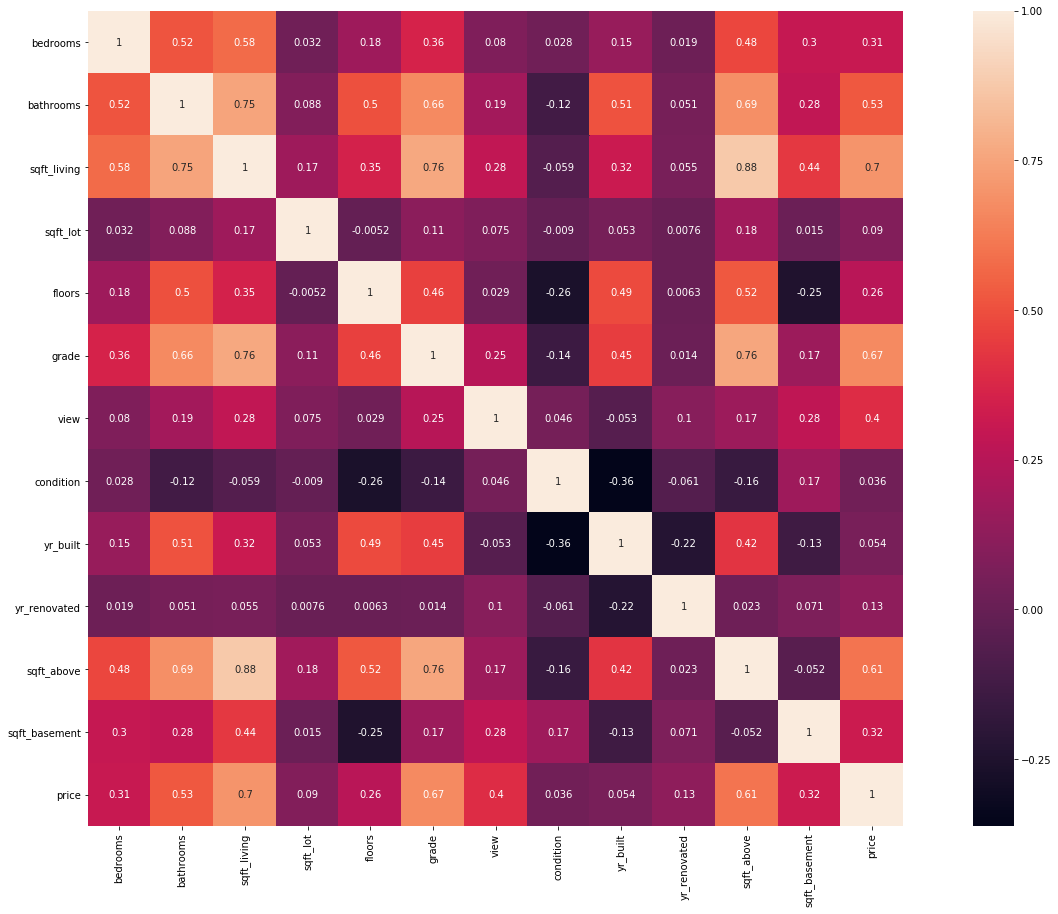

In [9]:
corrmat = df[["bedrooms","bathrooms","sqft_living","sqft_lot","floors","grade","view","condition","yr_built","yr_renovated","sqft_above","sqft_basement","price"]].corr()
fig,ax= plt.subplots()
fig.set_size_inches(25,15)
sns.heatmap(corrmat,square=True,annot=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1f87dd3048>,
      dtype=object)

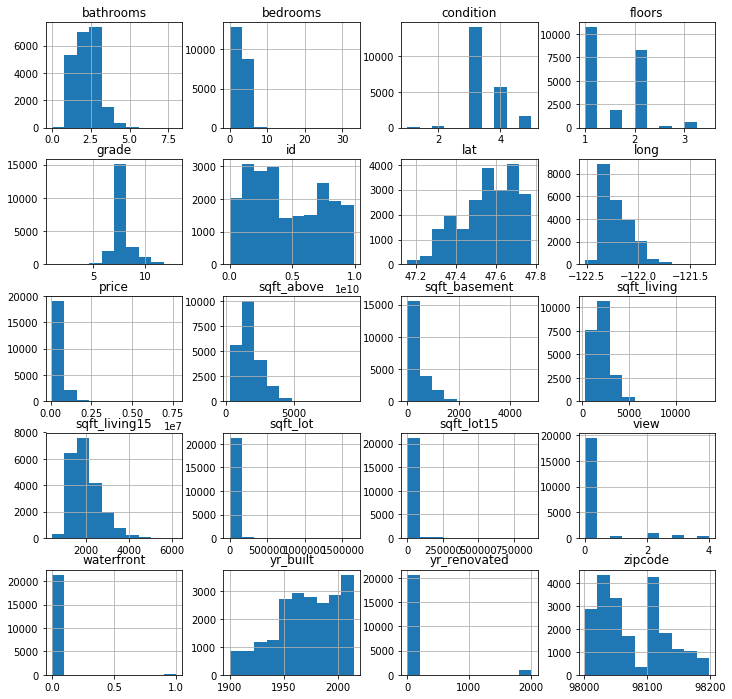

In [10]:
pd.DataFrame.hist(df,figsize=(12,12))

**Feature Engineering:**
**Calculating age of house from Date variable**

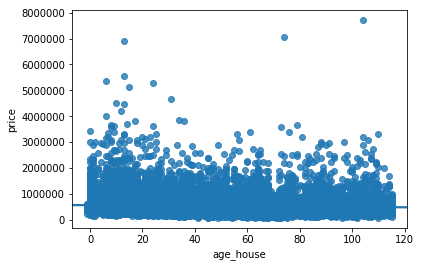

In [11]:

df['year_sold'] = df['date'].apply(lambda x: int(x[:4]))
df['age_house'] = df[['year_sold']].sub(df['yr_built'], axis=0)
sns.regplot(x="age_house",y="price",data=df)

Creating feature **Is_renovated** variable from year of renovation:

In [0]:
df['Is_renovated'] = df['yr_renovated'].apply(lambda x: 0 if x==0 else 1)

Converting zipcodes into categories

In [0]:
df = pd.get_dummies(df,columns=['zipcode'])

#Removing outliers from Price
df = df[df['price']<6000000]

removing variables which does not alter our model output. From the above exploration and visualization steps we have decided to remove these variables:

'id','date','sqft_lot','condition','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','year_sold','sqft_living15', 'sqft_lot15'



**Reducing the dimesion using PCA:**

In [0]:

main_features = ['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'age_house',
       'Is_renovated']
# Separating out the features
X2 = df[df.columns.difference(main_features)].values
# Separating out the target
y2 = df.loc[:,['price']].values
# Standardizing the features
X2 = StandardScaler().fit_transform(X2)

In [0]:
pca = PCA(n_components=65)
pcomp = pca.fit(X2)

In [0]:
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_

#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

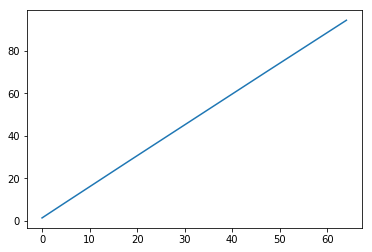

In [17]:
plt.plot(var1)

In [18]:
#Looking at above plot I'm taking 40 variables
pca = PCA(n_components=40)
pca.fit(X2)
pca_var=pca.fit_transform(X2)


principalDf = pd.DataFrame(data = pca_var)

df_pca = pd.concat([df[main_features], principalDf], axis = 1)
df_pca = df_pca.dropna(how='any')
print(df_pca)

                 id             date      price  ...        37        38        39
0      7.129301e+09  20141013T000000   221900.0  ... -1.312003 -0.563705  0.260459
1      6.414100e+09  20141209T000000   538000.0  ... -0.223551 -0.331423  0.162894
2      5.631500e+09  20150225T000000   180000.0  ...  0.173464 -0.648966 -0.013417
3      2.487201e+09  20141209T000000   604000.0  ...  0.485605 -0.440710  0.704002
4      1.954401e+09  20150218T000000   510000.0  ...  0.163336 -0.745621  0.391705
5      7.237550e+09  20140512T000000  1225000.0  ... -0.166561  0.221569 -0.252995
6      1.321400e+09  20140627T000000   257500.0  ...  0.046790 -1.388484  0.089949
7      2.008000e+09  20150115T000000   291850.0  ...  0.832524 -0.016932 -0.266573
8      2.414600e+09  20150415T000000   229500.0  ...  1.026902 -0.500281 -0.682964
9      3.793500e+09  20150312T000000   323000.0  ... -0.016499 -0.152635  0.075541
10     1.736801e+09  20150403T000000   662500.0  ... -2.032538  1.140307 -2.915847
11  

In [19]:
X_pca = df_pca[df_pca.columns.difference(['price','id','date','sqft_lot','condition','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','year_sold','sqft_living15', 'sqft_lot15'])]
y_pca = df_pca['price']


df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'year_sold', 'age_house',
       'Is_renovated', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003',
       'zipcode_98004', 'zipcode_98005', 'zipcode_98006', 'zipcode_98007',
       'zipcode_98008', 'zipcode_98010', 'zipcode_98011', 'zipcode_98014',
       'zipcode_98019', 'zipcode_98022', 'zipcode_98023', 'zipcode_98024',
       'zipcode_98027', 'zipcode_98028', 'zipcode_98029', 'zipcode_98030',
       'zipcode_98031', 'zipcode_98032', 'zipcode_98033', 'zipcode_98034',
       'zipcode_98038', 'zipcode_98039', 'zipcode_98040', 'zipcode_98042',
       'zipcode_98045', 'zipcode_98052', 'zipcode_98053', 'zipcode_98055',
       'zipcode_98056', 'zipcode_98058', 'zipcode_98059', 'zipcode_98065',
       'zipcode_98070', 'zipcode_98072

In [0]:
X = df[df.columns.difference(['price','id','date','sqft_lot','condition','sqft_above','sqft_basement','yr_built','yr_renovated','lat','long','year_sold','sqft_living15', 'sqft_lot15'])]
y = df['price']

In [21]:
print(X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


Index(['Is_renovated', 'age_house', 'bathrooms', 'bedrooms', 'floors', 'grade',
       'sqft_living', 'view', 'waterfront', 'zipcode_98001', 'zipcode_98002',
       'zipcode_98003', 'zipcode_98004', 'zipcode_98005', 'zipcode_98006',
       'zipcode_98007', 'zipcode_98008', 'zipcode_98010', 'zipcode_98011',
       'zipcode_98014', 'zipcode_98019', 'zipcode_98022', 'zipcode_98023',
       'zipcode_98024', 'zipcode_98027', 'zipcode_98028', 'zipcode_98029',
       'zipcode_98030', 'zipcode_98031', 'zipcode_98032', 'zipcode_98033',
       'zipcode_98034', 'zipcode_98038', 'zipcode_98039', 'zipcode_98040',
       'zipcode_98042', 'zipcode_98045', 'zipcode_98052', 'zipcode_98053',
       'zipcode_98055', 'zipcode_98056', 'zipcode_98058', 'zipcode_98059',
       'zipcode_98065', 'zipcode_98070', 'zipcode_98072', 'zipcode_98074',
       'zipcode_98075', 'zipcode_98077', 'zipcode_98092', 'zipcode_98102',
       'zipcode_98103', 'zipcode_98105', 'zipcode_98106', 'zipcode_98107',
       'zipcode_9

In [0]:
X_trainP, X_testP, y_trainP, y_testP = train_test_split(X_pca, y_pca, test_size=0.20, random_state=0)

**Build Linear Regression Models:**

In [0]:
def linear_model(X_train,y_train,X_test,y_test):
    lr = LinearRegression()
    lr.fit(X_train,y_train)
    ypred = lr.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,(ypred)))
    print("Root mean squared error: "+ str(rmse))
    r_squared = r2_score(y_test,ypred)
    print("R-squared value: "+ str(r_squared))
    sns.regplot(x=ypred,y=y_test)

Root mean squared error: 149318.43271062156
R-squared value: 0.8149400609305105


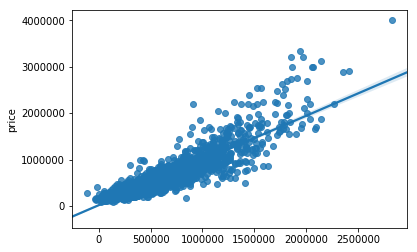

In [24]:
linear_model(X_train,y_train,X_test,y_test)

Root mean squared error: 207787.1359017612
R-squared value: 0.6627740037625873


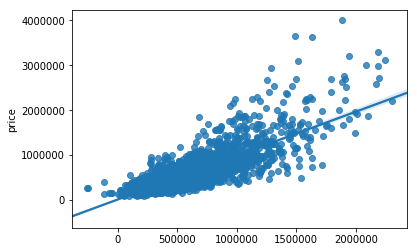

In [25]:
linear_model(X_trainP,y_trainP,X_testP,y_testP)